In [2]:
import sys
import functools
import numpy as np
from scipy.special import legendre
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt
import modepy

In [3]:
# Define the initial condition
def uinit(z):
    """Set the initial condition.

    z : ndarray
        Assume z is p+1 x nel
    """
    uu = np.zeros_like(z)
    for i in range(uu.shape[1]):
        if np.all(z[:, i] <= 0.5):
            # make sure the entire cell is less than 0.5
            uu[:, i] = 1.0
    J = np.where(z <= 0.25)
    uu[J] = 4 * z[J]
    return uu

In [4]:
# Set the mesh
def nlegendre(q):
    """Compute the Legendre with unite L2"""
    return legendre(q) / np.sqrt(2/(2*q+1))

class Mesh:
    """Mesh obejct, housing DG stuff."""
    def __init__(self, p, nel):
        xa, xb = (0, 1)
        self.p = p
        self.nel = nel

        self.a = 1
        qx = modepy.quadrature.jacobi_gauss.legendre_gauss_lobatto_nodes(p)
        self.qx = qx

        x = np.linspace(xa, xb, nel+1)
        self.x = x
        h = x[1] - x[0]
        self.h = h

        # full mesh, all nodes
        xx = np.zeros((p+1, nel))
        for e in range(nel):
            xx[:,e] = x[e] + (h/2)*(qx + 1)
        self.xx = xx

        V = np.zeros((p+1,p+1))
        dV = np.zeros((p+1,p+1))
        for q in range(p+1):
            poly = nlegendre(q)
            dpoly = poly.deriv()
            V[:, q] = poly(qx)
            dV[:, q] = dpoly(qx)
        Vinv = np.linalg.inv(V)
        M = Vinv.T @ Vinv
        Minv = (2/h) * V @ V.T
        S = M @ dV @ Vinv
        D = dV @ Vinv

        self.V = V
        self.Vinv = Vinv
        self.M = M
        self.S = S
        self.D = D
        self.Minv = Minv

        n = (p+1)*nel
        self.n = n

        I = np.arange(nel)
        self.I = I
        self.Im1 = np.roll(I, 1)
        self.Ip1 = np.roll(I, -1)

In [ ]:
def plotnodal(xx, u, ax=None):
    """Plot all of the nodal values."""
    if not ax:
        _, ax = plt.subplots()
    ax.plot(xx.ravel(order='F'), u.ravel(order='F'), '-o', ms=3)


def plotmodal(xx, u, mesh, u2=None):
    """High fidelity modal."""
    Vinv = mesh.Vinv
    nel = mesh.nel
    p = mesh.p
    c = Vinv @ u
    m = 40
    v = np.zeros((m, nel))
    zz = np.zeros((m, nel))
    z = np.linspace(-1, 1, m)
    for k in range(nel):
        zz[:, k] = xx[0, k] + (xx[p, k] - xx[0, k])*(z+1)/2
        for q in range(p+1):
            v[:, k] += c[q, k] * nlegendre(q)(z)

    zz = zz.ravel(order='F')
    plt.plot(zz, v.ravel(order='F'), '-o', ms=3)
    if u2 is not None:
        plt.plot(zz, u2(zz), color='tab:red', lw=1)
    plt.show()

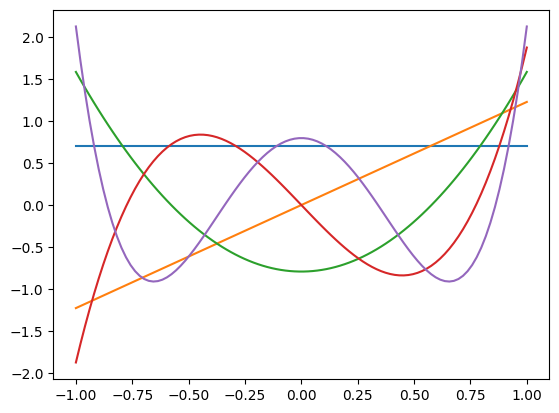

In [7]:
x = np.linspace(-1, 1, 100)
plt.plot(x, nlegendre(0)(x))
plt.plot(x, nlegendre(1)(x))
plt.plot(x, nlegendre(2)(x))
plt.plot(x, nlegendre(3)(x))
plt.plot(x, nlegendre(4)(x))

In [ ]:
T = 1
dt = 0.0001
nstep = int(np.ceil(T/dt))
step = 0
mesh = Mesh(p=6, nel=100)
M = mesh.M
xx = mesh.xx
u = uinit(xx)

In [ ]:
def mytest(test):
    @functools.wraps(test)
    def wrapper():
        test()
        print(f'{test.__name__}: pass')
    return wrapper

@mytest
def test1():
    pass

test1()